In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.ode import IVP, Monitor, solve_system
from scipy.integrate import odeint
from neurodiffeq.pde import DirichletBVP2D, solve2D, ExampleGenerator2D, Monitor2D
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>


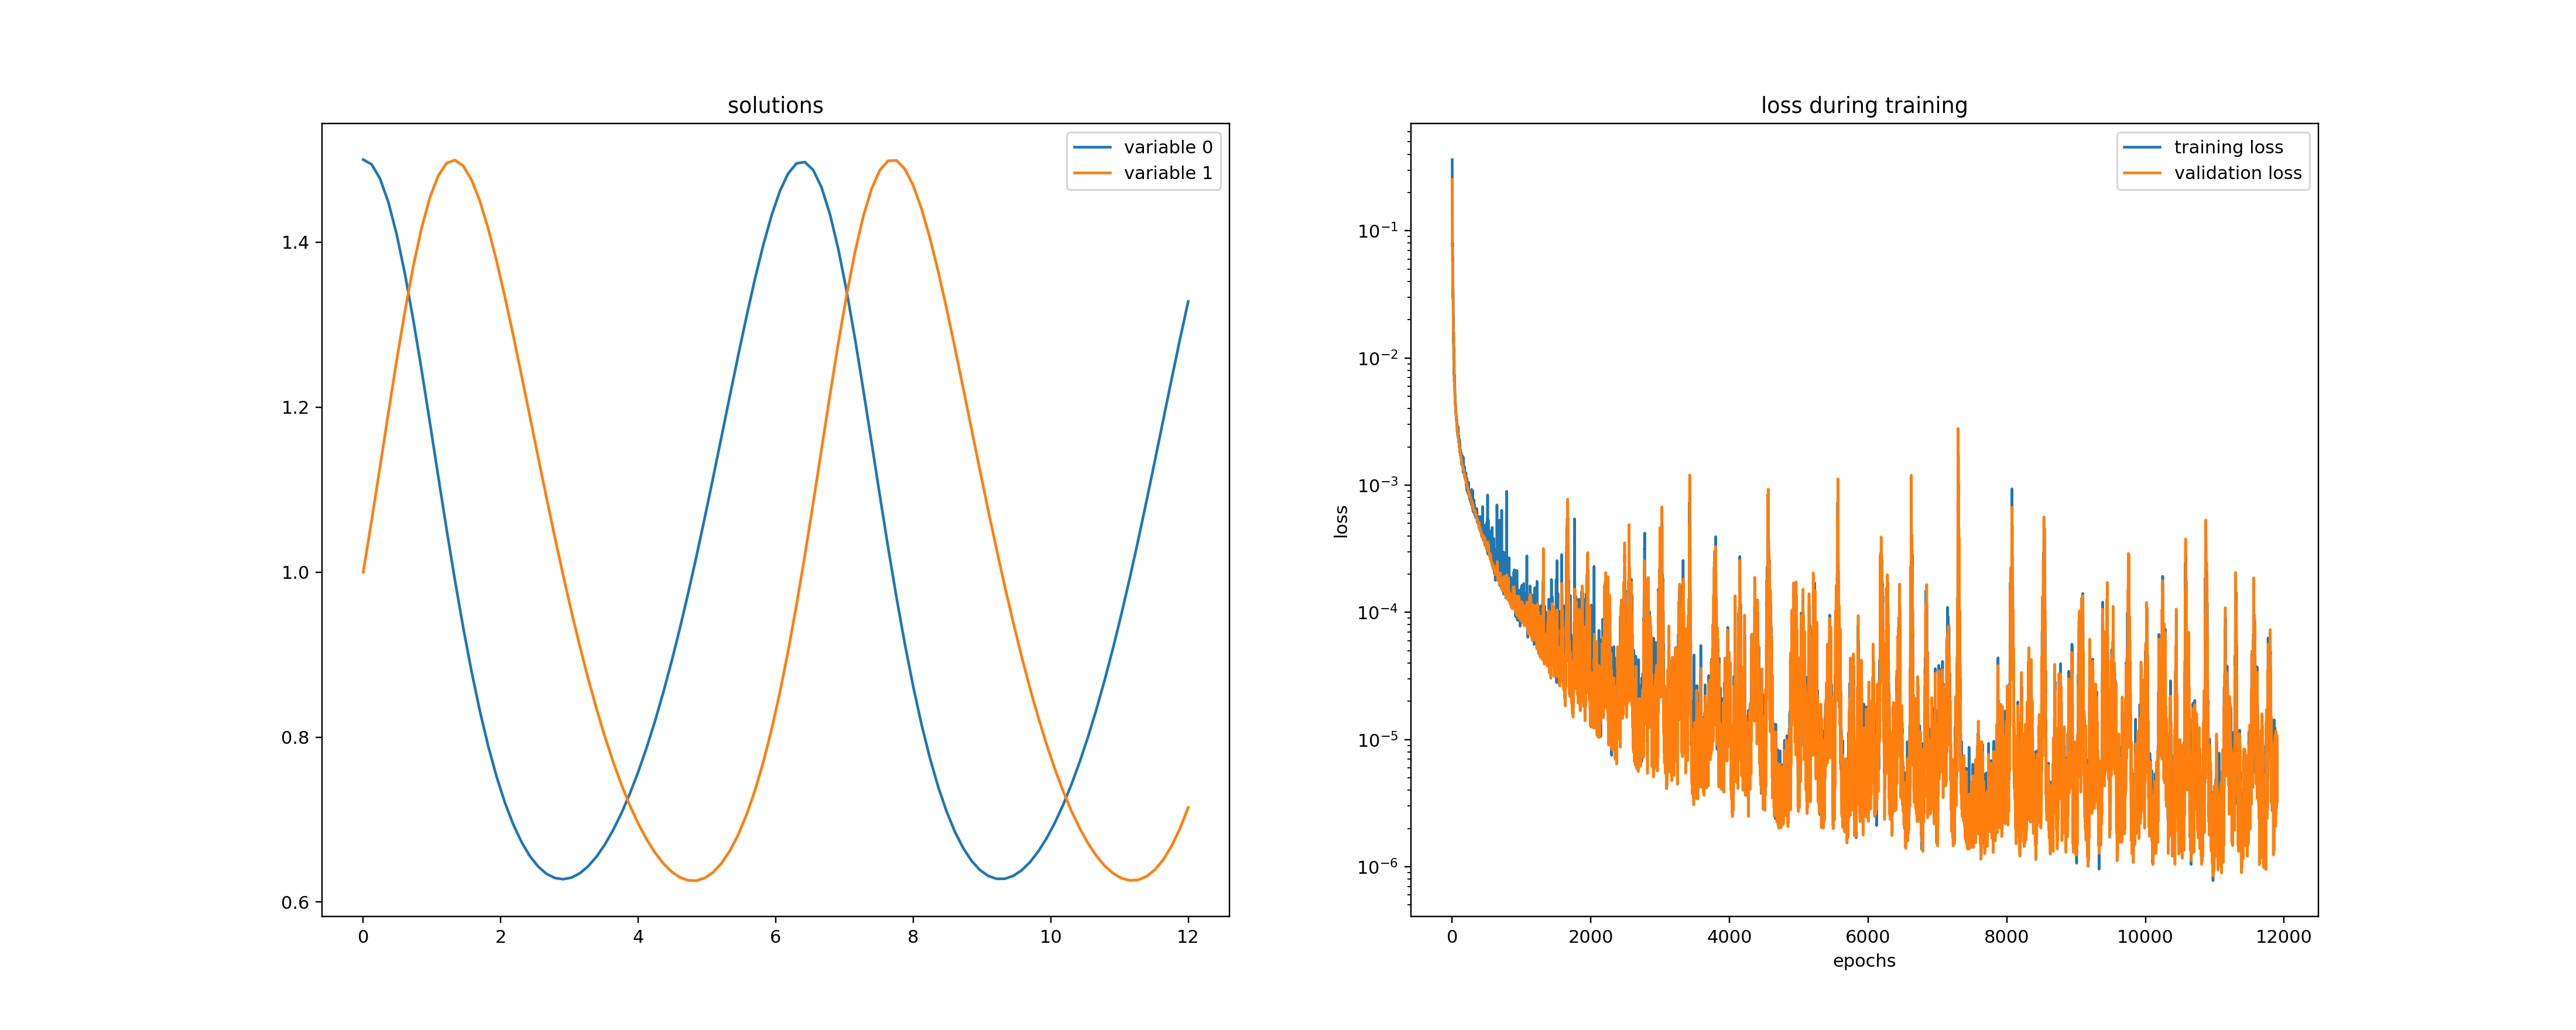

In [2]:
%matplotlib notebook
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda x, y, t : [diff(x, t) - (alpha*x  - beta*x*y), 
                                   diff(y, t) - (delta*x*y - gamma*y)]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, x_0=1.5),
    IVP(t_0=0.0, x_0=1.0)
]

# specify the network to be used to approximate each dependent variable
nets_lv = [
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv),
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, 
    nets=nets_lv, max_epochs=12000,
    monitor=Monitor(t_min=0.0, t_max=12, check_every=100)
)

<IPython.core.display.Javascript object>


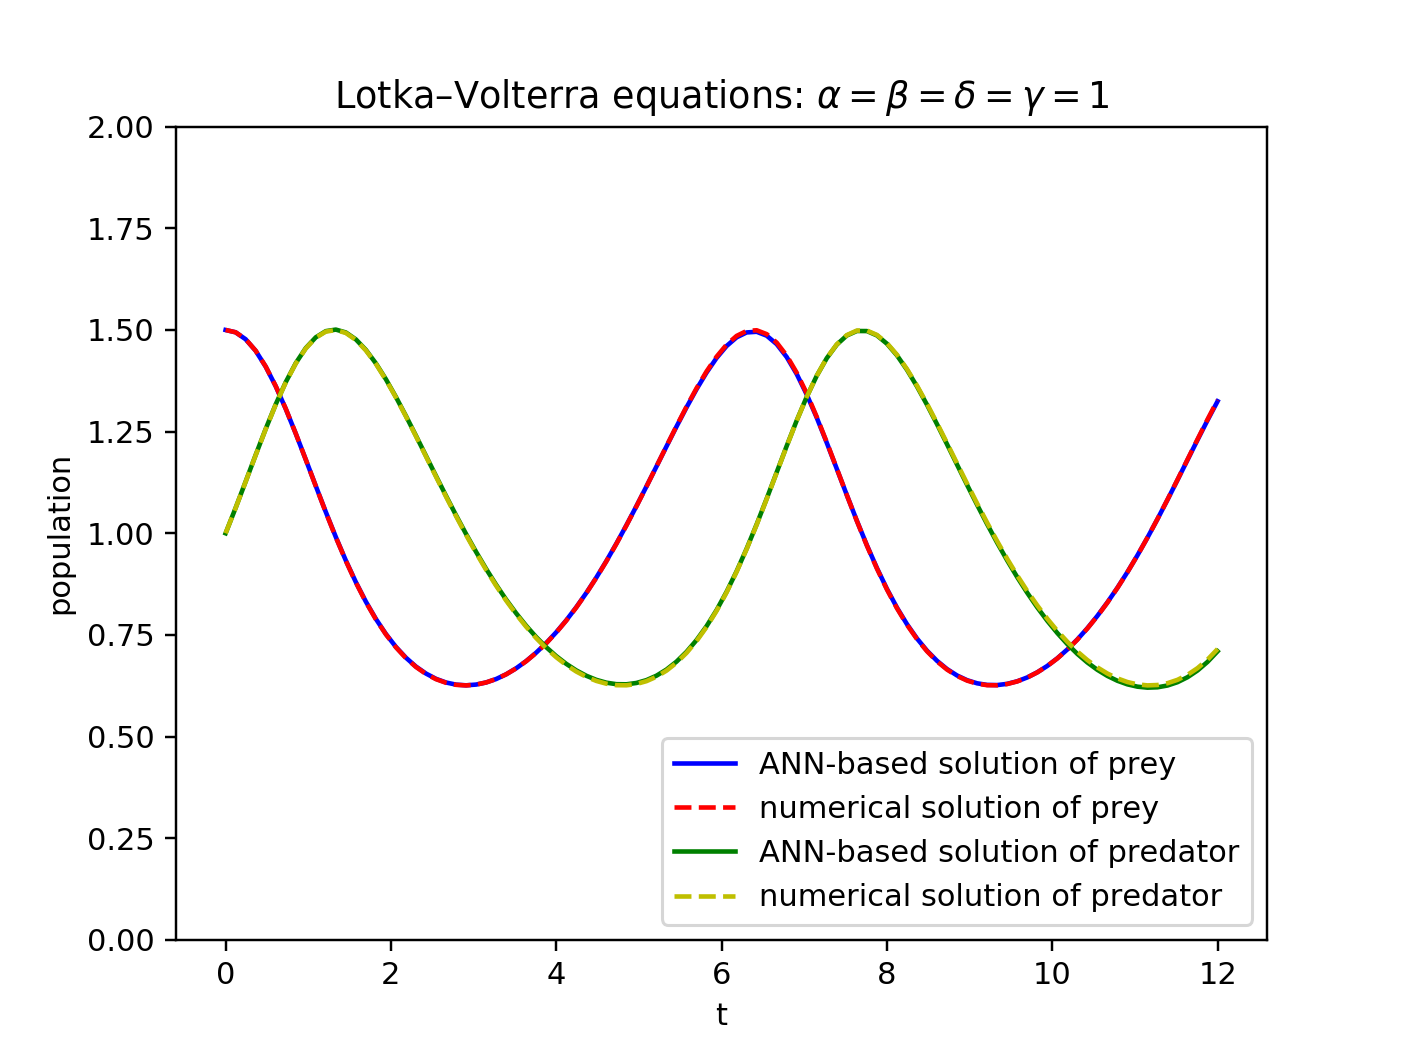

In [3]:
%matplotlib notebook
ts = np.linspace(0, 12, 100)

# ANN-based solution
prey_net, pred_net = solution_lv(ts, as_type='np')

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, ts)
prey_num = Ps[:,0]
pred_num = Ps[:,1]

plt.figure()
plt.plot(ts, prey_net, 'b-', label='ANN-based solution of prey')
plt.plot(ts, prey_num, 'r--', label='numerical solution of prey')
plt.plot(ts, pred_net, 'g-', label='ANN-based solution of predator')
plt.plot(ts, pred_num, 'y--', label='numerical solution of predator')
plt.ylim(0, 2)
plt.ylabel('population')
plt.xlabel('t')
plt.title('Lotka–Volterra equations: $\\alpha = \\beta = \\delta = \\gamma = 1$')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


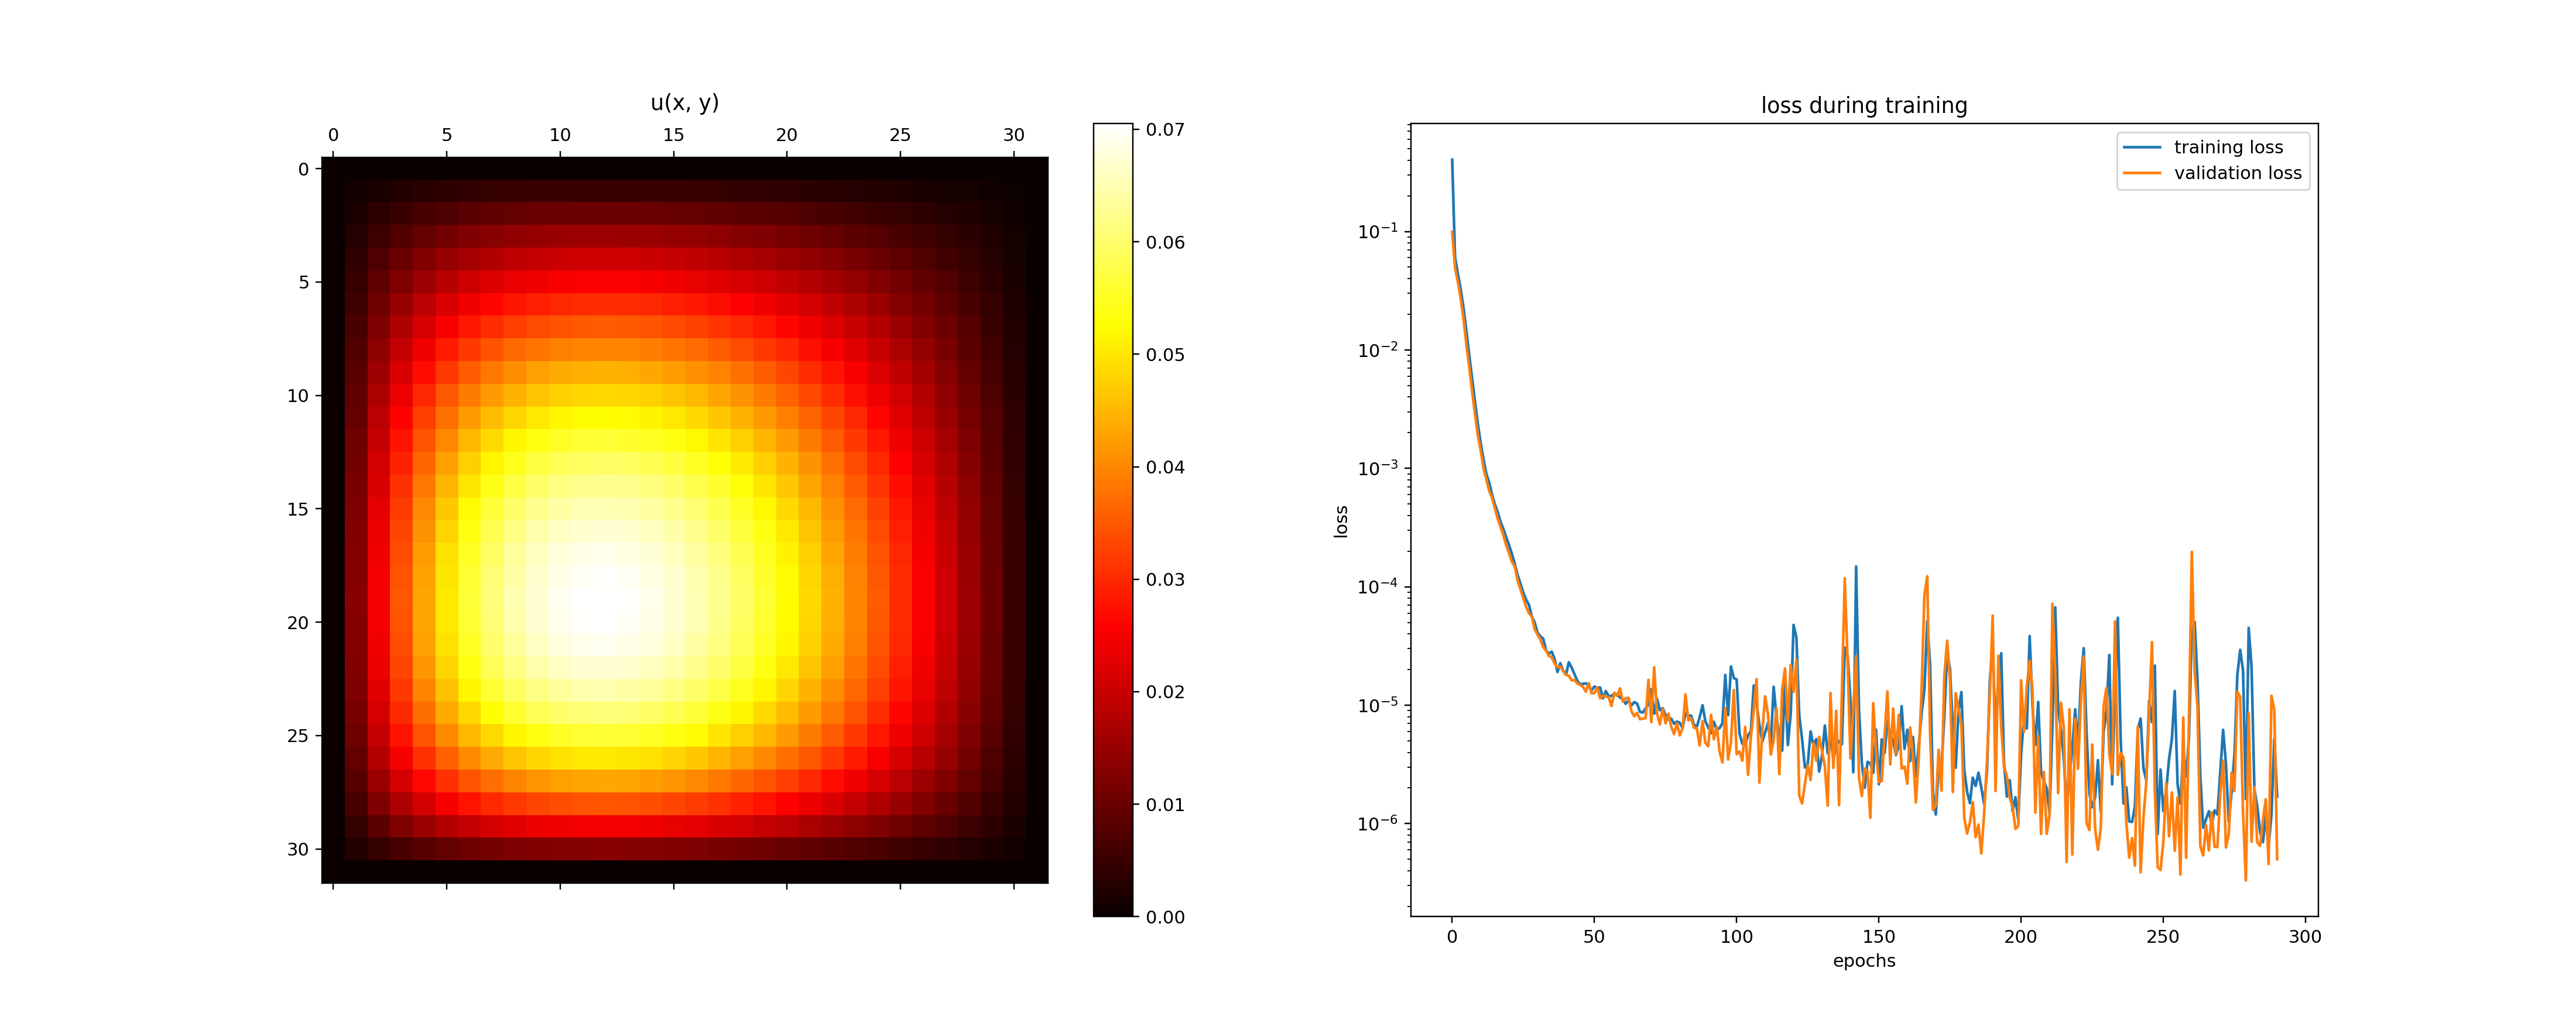

In [4]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 2*x*(y-1)*(y-2*x+x*y+2)*torch.exp(x-y)
bc = DirichletBVP2D(
    x_min=0, x_min_val=lambda y: 0, 
    x_max=1, x_max_val=lambda y: 0, 
    y_min=0, y_min_val=lambda x: 0, 
    y_max=1, y_max_val=lambda x: 0
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(0, 0), xy_max=(1, 1),
    net=net, max_epochs=300, train_generator=ExampleGenerator2D(
        (32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1))
)

In [5]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
solution_analytical_laplace = lambda x, y: np.exp(x-y)*x*(1-x)*y*(1-y)
sol_ana = solution_analytical_laplace(xx, yy)
sol_net = solution_neural_net_poisson(xx, yy, as_type='np')

<IPython.core.display.Javascript object>


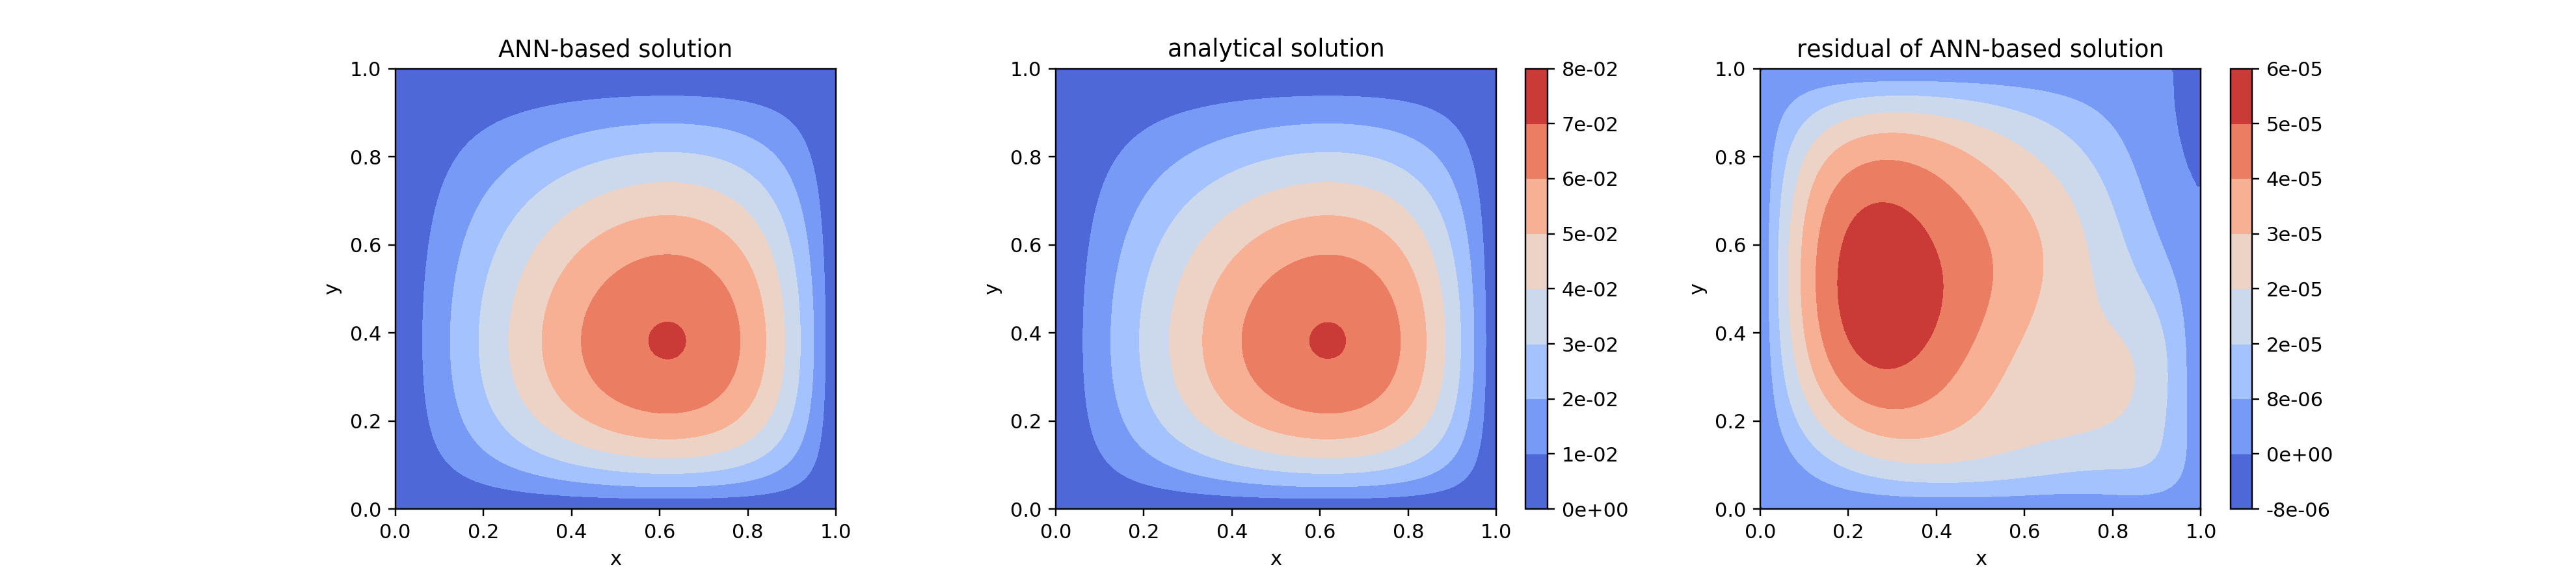

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(18, 4))

ax1 = fig.add_subplot(131)
cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('ANN-based solution')

ax2 = fig.add_subplot(132)
cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('analytical solution')
cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

ax3 = fig.add_subplot(133)
cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title('residual of ANN-based solution')
cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)